In [30]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests

sns.set_style('whitegrid')
dir_enigh_2020 = 'datos/enigh_2020/'

print('Python', sys.version)
for lb in [pd, np, sns, plt.matplotlib]:
    print(lb.__name__, lb.__version__)

Python 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
pandas 1.2.4
numpy 1.20.1
seaborn 0.11.1
matplotlib 3.3.4


In [2]:
def total_ponderado(df, variable, factor='factor'):
    return df[variable].mul(df[factor]).sum()


def promedio_ponderado(df, variable, factor='factor', by=None):
    def _promedio_individual(df, variable, factor=factor):
        return df[variable].mul(df[factor]).sum()/df.loc[df[variable].notnull(), factor].sum()

    if by:
        out = df.groupby(by).apply(_promedio_individual, variable=variable, factor=factor)
    else:
        out = _promedio_individual(df=df, variable=variable, factor=factor)
    return out


def tabla_ponderado(df, variable, factor='factor'):
    return df.groupby(variable)[factor].sum()


def porcentaje(s):
    if hasattr(s.index, 'levels'):
        ndims = len(s.index.levels)
        levs = list(range(ndims-1))
        out = s.div(s.sum(level=levs)).mul(100)
    else:
        out = s.div(s.sum()).mul(100)
    return out

# Formas alternativas de pago en micronegocios familiares

# Datasets

## Hogares

In [63]:
variables_hogar = ['folioviv', 'foliohog', 'est_socio', 'ubica_geo', 'tam_loc', 'factor', 'est_dis', 'upm', 'ing_cor', 'negocio']
hogares = pd.read_stata(f'{dir_enigh_2020}/concentradohogar.dta', columns=variables_hogar)\
    .assign(estado=lambda x: x['ubica_geo'].str[0:2].astype(int))
hogares.head()

,folioviv,foliohog,est_socio,ubica_geo,tam_loc,factor,est_dis,upm,ing_cor,negocio,estado
0,0100013605,1,3,01001,1,190.0,002,0000001,16229.49,1573.77,1
1,0100013606,1,3,01001,1,190.0,002,0000001,31425.68,0.00,1
2,0100017801,1,3,01001,1,189.0,002,0000002,33979.16,9880.81,1
3,0100017802,1,3,01001,1,189.0,002,0000002,71557.37,0.00,1
4,0100017803,1,3,01001,1,189.0,002,0000002,90703.26,0.00,1


In [4]:
hogares_2 = pd.read_stata(f'{dir_enigh_2020}/hogares.dta', columns=['folioviv', 'foliohog', 'conex_inte', 'celular'])
hogares_2.head()

,folioviv,foliohog,conex_inte,celular
0,0100013605,1,1,1
1,0100013606,1,1,1
2,0100017801,1,1,1
3,0100017802,1,1,1
4,0100017803,1,1,1


## Personas

In [5]:
variables_persona = ['folioviv', 'foliohog', 'numren', 'sexo', 'edad', 'hablaind', 'alfabetism', 'nivelaprob', 'redsoc_3', 'hor_1', 'hor_4']
personas = pd.read_stata(f'{dir_enigh_2020}/poblacion.dta', columns=variables_persona)
personas.head()

,folioviv,foliohog,numren,sexo,edad,hablaind,alfabetism,nivelaprob,redsoc_3,hor_1,hor_4
0,0100013605,1,01,2,48.0,2,1,7,2,50.0,NaN
1,0100013605,1,02,2,17.0,2,1,4,2,NaN,NaN
2,0100013605,1,03,1,14.0,2,1,3,2,NaN,NaN
3,0100013606,1,01,1,46.0,2,1,4,2,80.0,NaN
4,0100013606,1,02,2,43.0,2,1,6,1,NaN,NaN


## Etiquetas de valores

In [6]:
# Diccionario de variables
dicc_var_negocios = pd.io.stata.StataReader(f'{dir_enigh_2020}/noagro.dta').variable_labels()

# Diccionarop de valores de variables
dicc_values_negocio = dict()
dicc_values_negocio['otro_pago'] = {'1': 'sí', '2': 'No'}
dicc_values_negocio['sexo'] = {'1': 'Hombre', '2': 'Mujer'}
dicc_values_negocio['estado'] = pd.read_csv(f'{dir_enigh_2020}/ent.csv', encoding='latin1').set_index('CVE_ENT').get('NOM_ENT').to_dict()

dicc_values_negocio['nofpago'] = {
    '1': 'Tamaño del negocio',
    '2': 'Desconocimiento de otras modalidades',
    '3': 'Por costos de operación',
    '4': 'Falta de infraestructura o equipo',
    '5': 'Desconfianza de otras formas de pago',
    '6': 'No lo cree necesario',
    '7': 'Otro',
    ' ': 'NS/NR',
}

dicc_values_negocio['nivelaprob'] = {
    '0': 'Primaria o menos',
    '1': 'Primaria o menos',
    '2': 'Primaria o menos',
    '3': 'Secundaria o preparatoria',
    '4': 'Secundaria o preparatoria',
    '5': 'Normal o técnica',
    '6': 'Normal o técnica',
    '7': 'Profesional',
    '8': 'Maestría o doctorado',
    '9': 'Maestría o doctorado',
}

dicc_values_negocio['est_socio'] = {
    '1': 'Bajo',
    '2': 'Medio bajo',
    '3': 'Medio alto',
    '4': 'Alto',
}

dicc_values_negocio['tipoact'] = {
    '1': 'Industrial',
    '2': 'Compra-Venta',
    '3': 'Servicios',
}

dicc_values_negocio['tam_loc'] = {
    '1': '100,000 y más habitantes',
    '2': '15,000 a 99,999 habitantes',
    '3': '2,500 a 14,999 habitantes',
    '4': 'Menos de 2,500 habitantes',
}


dicc_values_negocio['reg_cont'] = {'2': 'sí', '3': 'sí', '4': 'No'}
dicc_values_negocio['conex_inte'] = {'1': 'sí', '2': 'No'}
dicc_values_negocio['celular'] = {'1': 'sí', '2': 'No'}

## Negocios de los hogares

In [65]:
negocios = pd.read_stata(f'{dir_enigh_2020}/noagro.dta')\
    .merge(hogares, on=['folioviv', 'foliohog'], how='left')\
    .merge(hogares_2, on=['folioviv', 'foliohog'], how='left')\
    .merge(personas, on=['folioviv', 'foliohog', 'numren'], how='left')\
    .replace(dicc_values_negocio)

# Recibe forma de pago alternativa
negocios['fpago_alt'] = negocios['otro_pago'].eq('sí')

# Creamos variable de ingreso mensual
negocios['ingreso_mensual'] = negocios['ing_tri'].div(3)

negocios['ingreso_mensual_rango'] = pd.cut(negocios['ingreso_mensual'],
                                           bins=[0, 2000, 4000, 6000, 8000, np.inf],
                                           labels=['0-2000', '2001-4000', '4001-6000', '6001-8000', '8000 o más'],
                                           right=False
                                          )


negocios['tiene_empleados'] = negocios['t_emp'].gt(0)  # Creamos variable si emplea a más de una persona
negocios['mujer'] = negocios['sexo'].eq('Mujer')
negocios['tiene_internet'] = negocios['conex_inte'].eq('sí')
negocios['tiene_celular'] = negocios['celular'].eq('sí')
negocios['tiene_contabilidad'] = negocios['reg_cont'].eq('sí')


negocios['part_negocio'] = negocios['negocio'].div(negocios['ing_cor']).mul(100)
negocios.head()

,folioviv,foliohog,numren,id_trabajo,tipoact,numesta,totesta,lugact,socios,numsocio,...,hor_4,fpago_alt,ingreso_mensual,ingreso_mensual_rango,tiene_empleados,mujer,tiene_internet,tiene_celular,tiene_contabilidad,part_negocio
0,0100013605,1,01,1,Compra-Venta,1,NaN,3,2,NaN,...,NaN,False,524.590000,0-2000,False,True,True,True,False,9.696978
1,0100017801,1,02,1,Compra-Venta,2,NaN,,2,NaN,...,12.0,False,3293.603333,2001-4000,False,True,True,True,True,29.079030
2,0100021402,1,01,1,Compra-Venta,2,NaN,,2,NaN,...,NaN,False,2886.520000,2001-4000,False,False,False,True,False,35.047057
3,0100021405,1,01,1,Servicios,1,NaN,1,2,NaN,...,NaN,False,0.000000,0-2000,False,True,False,False,False,0.000000
4,0100041902,1,01,1,Compra-Venta,2,NaN,,2,NaN,...,NaN,False,1353.260000,0-2000,True,True,True,True,True,23.316190


## Datos para modelo

In [8]:
vars_modelo = ['folioviv', 'foliohog', 'est_dis', 'upm', 'factor', 'fpago_alt', 'tipoact', 'mujer', 'edad', 'nivelaprob', 'est_socio',
               'tam_loc', 'tiene_empleados', 'ingreso_mensual', 'ingreso_mensual_rango', 'tiene_internet', 'tiene_celular', 'tiene_contabilidad']

vars_categoria = ['tipoact', 'nivelaprob', 'est_socio', 'tam_loc']
datos_modelo = negocios[vars_modelo].copy()
for v in vars_categoria:
    datos_modelo[v] = datos_modelo[v].astype('category')

datos_modelo.to_stata(f'{dir_enigh_2020}/datos_modelo.dta')
datos_modelo.head()

,folioviv,foliohog,est_dis,upm,factor,fpago_alt,tipoact,mujer,edad,nivelaprob,est_socio,tam_loc,tiene_empleados,ingreso_mensual,ingreso_mensual_rango,tiene_internet,tiene_celular,tiene_contabilidad
0,0100013605,1,002,0000001,190.0,False,Compra-Venta,True,48.0,Profesional,Medio alto,"100,000 y más habitantes",False,524.590000,0-2000,True,True,False
1,0100017801,1,002,0000002,189.0,False,Compra-Venta,True,26.0,Profesional,Medio alto,"100,000 y más habitantes",False,3293.603333,2001-4000,True,True,True
2,0100021402,1,002,0000003,168.0,False,Compra-Venta,False,74.0,Primaria o menos,Medio alto,"100,000 y más habitantes",False,2886.520000,2001-4000,False,True,False
3,0100021405,1,002,0000003,168.0,False,Servicios,True,79.0,Primaria o menos,Medio alto,"100,000 y más habitantes",False,0.000000,0-2000,False,False,False
4,0100041902,1,002,0000004,211.0,False,Compra-Venta,True,46.0,Secundaria o preparatoria,Medio alto,"100,000 y más habitantes",True,1353.260000,0-2000,True,True,True


# Análisis

* 28% de los hogares tiene un negocio o actividad propia

In [71]:
negocios['factor'].sum()

10088738.0

In [59]:
negocios['factor'].sum() / hogares['factor'].sum()

0.2822051533414626

In [68]:
promedio_ponderado(negocios, 'negocio') / 3

4836.453303266474

In [69]:
promedio_ponderado(negocios, 'part_negocio')

33.51502293589451

* A nivel nacional solo 9.9% de los micronegocios familiares recibe formas alternativas de pago

In [9]:
tabla_ponderado(negocios, ['otro_pago']).pipe(porcentaje).round(2)

otro_pago
No    90.12
sí     9.88
Name: factor, dtype: float64

* La forma de pago alternativa más común son las transferencias electrónicas, con 7.6% de los negocios, y con mucho menor frecuencia tarjeta débito (1.87%) y crédito (1.33%)

In [74]:
dicc_fpago = {
    'fpago_1': 'Domicialización',
    'fpago_2': 'Transferencia electrónica',
    'fpago_3': 'Tarjeta de crédito',
    'fpago_4': 'Tarjeta débito',
    'fpago_5': 'Cheque',
    'fpago_6': 'Vale',
    'fpago_7': 'Pago móvil',
    'fpago_8': 'Otra forma',
}

dataplot_fpago = pd.Series({v: tabla_ponderado(negocios, [k]).pipe(porcentaje).round(2).loc[k[-1]] for k, v in dicc_fpago.items()}).sort_values(ascending=True)
dataplot_fpago

Domicialización              0.08
Vale                         0.21
Pago móvil                   0.43
Otra forma                   0.56
Cheque                       0.87
Tarjeta de crédito           1.33
Tarjeta débito               1.87
Transferencia electrónica    7.59
dtype: float64

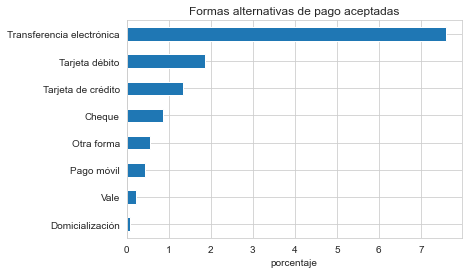

In [73]:
ax = dataplot_fpago.plot.barh()
ax.set_title('Formas alternativas de pago aceptadas')
ax.set_xlabel('porcentaje')
ax.set_ylabel('')

ax.figure.savefig('graficas/01_formas_pago.png', dpi=600, bbox_inches='tight')

* La principales razones por la que los hogares no aceptan medios de pago distintos al efectivo son porque "no lo cree necesario" (45%) o por el "tamaño del negocio" (35%). Muy pocos argumentan que la razón es el desconocimiento de las modalidades de pago, el costo o la desconfianza.

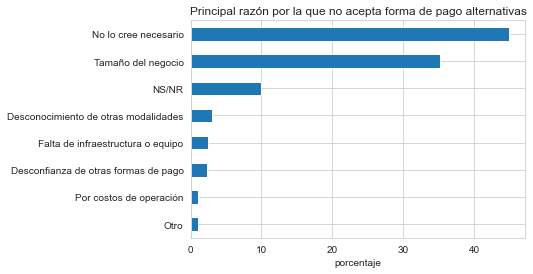

In [24]:
dataplot_nofpago = tabla_ponderado(negocios, ['nofpago']).pipe(porcentaje).round(2).sort_values()
ax = dataplot_nofpago.plot.barh()
ax.set_title('Principal razón por la que no acepta forma de pago alternativas')
ax.set_xlabel('porcentaje')
ax.set_ylabel('')
ax.figure.savefig('graficas/02_razones_no_pago.png', dpi=600, bbox_inches='tight')

## Por estado

In [12]:
dataplot_otropago_edo = tabla_ponderado(negocios, ['estado', 'otro_pago']).pipe(porcentaje).unstack('otro_pago')['sí'].sort_values(ascending=True)
dataplot_otropago_edo

estado
Chiapas                             3.784073
Tlaxcala                            4.265860
Zacatecas                           4.859188
Guanajuato                          5.296580
Guerrero                            5.401501
Oaxaca                              5.842918
Puebla                              6.071356
Tamaulipas                          6.655100
Durango                             6.948594
Michoacán de Ocampo                 7.066432
San Luis Potosí                     8.183921
Morelos                             8.233022
Veracruz de Ignacio de la Llave     8.504662
Nayarit                             9.210946
Jalisco                             9.363815
Hidalgo                            10.208575
Baja California                    10.436491
Coahuila de Zaragoza               10.841829
México                             11.137524
Yucatán                            11.399338
Tabasco                            11.934927
Aguascalientes                     13.657797
Qui

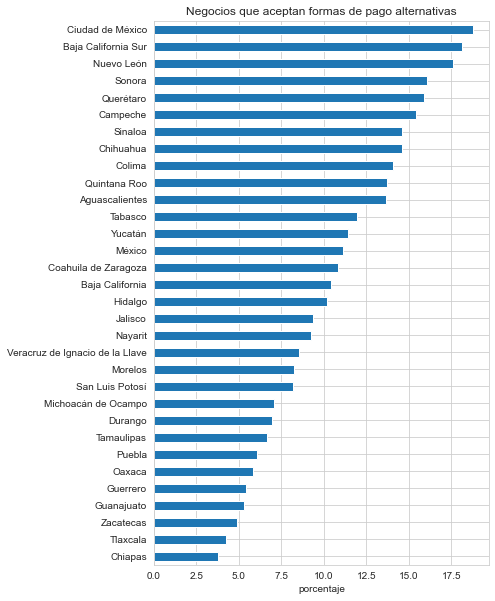

In [25]:
ax = dataplot_otropago_edo.plot.barh(figsize=(6, 10))
ax.set_title('Negocios que aceptan formas de pago alternativas')
ax.set_xlabel('porcentaje')
ax.set_ylabel('')
ax.figure.savefig('graficas/03_pago_alt_estados.png', dpi=600, bbox_inches='tight')

### Forma de pago aceptada por estado

In [14]:
dataplot_fpago_edo = pd.concat([
    tabla_ponderado(negocios, ['estado', k]).pipe(porcentaje).round(2).drop(' ', level=1).droplevel(1).to_frame(v)
    for k, v in dicc_fpago.items()
    ], axis=1
).sort_index()
dataplot_fpago_edo

,Domicialización,Transferencia electrónica,Tarjeta de crédito,Tarjeta débito,Cheque,Vale,Pago móvil,Otra forma
estado,,,,,,,,
Aguascalientes,0.26,8.87,2.94,4.04,1.64,0.09,0.44,0.35
Baja California,0.28,8.01,0.85,1.61,0.99,0.31,0.62,0.02
Baja California Sur,NaN,16.21,1.36,2.86,1.64,0.32,NaN,0.49
Campeche,0.09,13.06,0.67,1.00,0.49,0.35,0.85,1.29
Chiapas,NaN,2.77,NaN,0.28,0.36,NaN,NaN,0.85
Chihuahua,0.35,11.41,2.52,3.36,1.90,0.22,0.26,0.53
Ciudad de México,0.26,13.28,4.54,6.36,1.20,0.81,1.65,0.86
Coahuila de Zaragoza,0.25,7.16,2.87,4.01,0.35,0.14,0.29,NaN
Colima,NaN,11.06,1.53,1.66,2.04,0.15,NaN,2.02


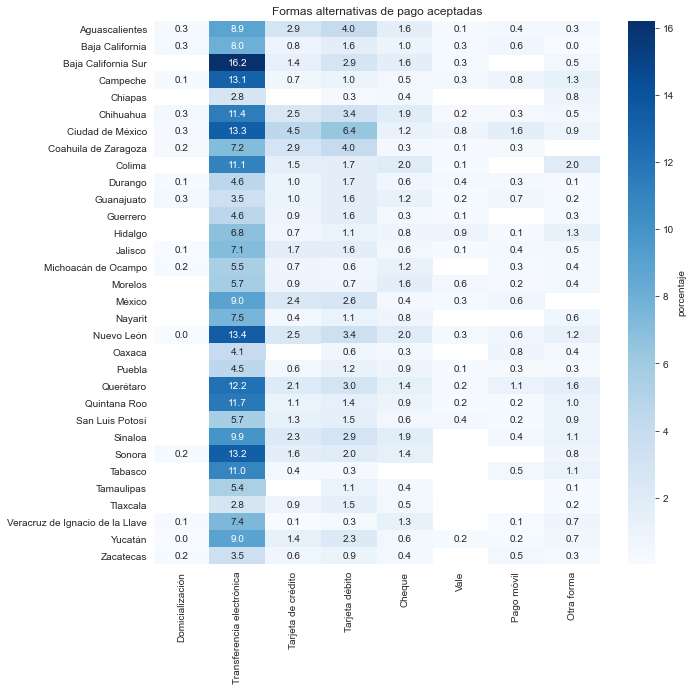

In [26]:
ax = sns.heatmap(dataplot_fpago_edo, cmap='Blues', annot=True, fmt='.1f', yticklabels=dataplot_fpago_edo.index, cbar_kws={'label': 'porcentaje'})
ax.set_title('Formas alternativas de pago aceptadas')
ax.figure.set_size_inches(10, 10)
ax.set_ylabel('')
ax.tick_params(axis='x')
ax.figure.savefig('graficas/04_pago_alt_estados_foma.png', dpi=600, bbox_inches='tight')

## Por sexo y nivel educativo de la persona encargada del negocio

In [16]:
orden_nivelaprob = ['Primaria o menos', 'Secundaria o preparatoria', 'Normal o técnica', 'Profesional', 'Maestría o doctorado']
dataplot_nivelaprob = tabla_ponderado(negocios, ['nivelaprob', 'sexo', 'otro_pago']).pipe(porcentaje).unstack('otro_pago')['sí'].unstack('sexo').loc[reversed(orden_nivelaprob)]
dataplot_nivelaprob

sexo,Hombre,Mujer
nivelaprob,,
Maestría o doctorado,51.663371,51.303493
Profesional,33.648301,26.823012
Normal o técnica,19.401824,10.525833
Secundaria o preparatoria,10.276097,6.434292
Primaria o menos,3.472876,0.864962


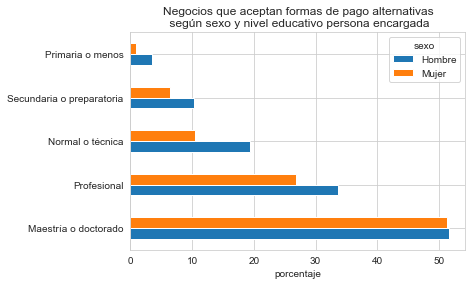

In [27]:
ax = dataplot_nivelaprob.plot.barh(figsize=(6, 4))
ax.set_title('Negocios que aceptan formas de pago alternativas\n según sexo y nivel educativo persona encargada')
ax.set_xlabel('porcentaje')
ax.set_ylabel('')
ax.figure.savefig('graficas/05_pago_alt_sexo_educacion.png', dpi=600, bbox_inches='tight')

## Según estatus socioeconómico del hogar

In [18]:
orden_estsoc = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']
dataplot_est_soc = tabla_ponderado(negocios, ['est_socio', 'conex_inte', 'otro_pago']).pipe(porcentaje).unstack('otro_pago')['sí'].unstack('conex_inte').loc[reversed(orden_estsoc)]
dataplot_est_soc

conex_inte,No,sí
est_socio,,
Alto,7.654714,36.113996
Medio alto,7.018499,20.036244
Medio bajo,4.036911,10.040026
Bajo,2.206279,6.654708


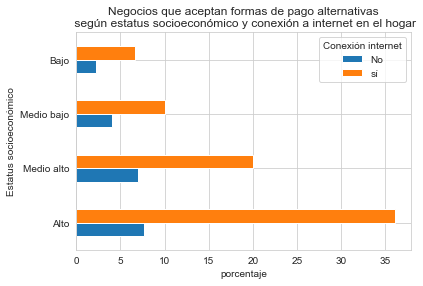

In [28]:
ax = dataplot_est_soc.plot.barh(figsize=(6, 4))
ax.set_title('Negocios que aceptan formas de pago alternativas\n según estatus socioeconómico y conexión a internet en el hogar')
ax.set_xlabel('porcentaje')
ax.set_ylabel('Estatus socioeconómico')
ax.legend(title='Conexión internet')
ax.figure.savefig('graficas/06_pago_alt_internet_estatus.png', dpi=600, bbox_inches='tight')

## Según nivel de ingreso del negocio

In [20]:
dataplot_ingreso = tabla_ponderado(negocios, ['reg_cont', 'ingreso_mensual_rango', 'otro_pago']).pipe(porcentaje).unstack('otro_pago')['sí']\
    .unstack('reg_cont')
dataplot_ingreso

reg_cont,No,sí
ingreso_mensual_rango,,
0-2000,5.318262,18.094458
2001-4000,5.838581,19.925742
4001-6000,7.514382,26.437982
6001-8000,9.769474,25.764889
8000 o más,11.932501,36.241656


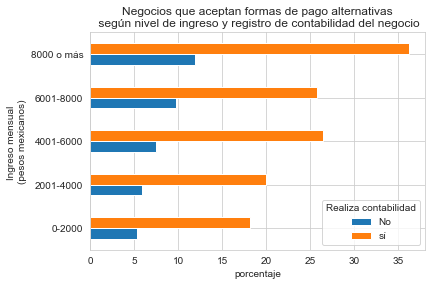

In [29]:
ax = dataplot_ingreso.plot.barh(figsize=(6, 4))
ax.set_title('Negocios que aceptan formas de pago alternativas\n según nivel de ingreso y registro de contabilidad del negocio')
ax.set_xlabel('porcentaje')
ax.set_ylabel('Ingreso mensual \n(pesos mexicanos)')
ax.legend(title='Realiza contabilidad')
ax.figure.savefig('graficas/07_pago_alt_ingreso_contabilidad.png', dpi=600, bbox_inches='tight')

# DataMéxico

## Unidades económicas que no tuvieron cuenta bancaria

In [40]:
url_censo = 'https://api.datamexico.org/tesseract/cubes/indicators_economic_census/aggregate.jsonrecords?captions%5B%5D=Category.Category.Category.Category+ES&captions%5B%5D=Indicator.Indicator.Indicator.Indicator+ES&cuts%5B%5D=Indicator.Indicator.Indicator.1%2C9%2C10%2C11%2C12%2C121%2C124%2C125&drilldowns%5B%5D=Category.Category.Category&drilldowns%5B%5D=Indicator.Indicator.Indicator&measures%5B%5D=Value&parents=false&sparse=false'
resp = requests.get(url_censo)
df_ue_cuenta = pd.DataFrame(resp.json()['data'])\
    .set_index('Category')
df_ue_cuenta.head()

,Category ID,Indicator ID,Indicator,Value
Category,,,,
No aplica,0,121,Unidades económicas que manejaron cuenta banca...,3740404
Hasta 10 personas,1,1,Unidades económicas que no contaron con crédit...,563174
Hasta 10 personas,1,9,Unidades económicas que no contaron con cuenta...,510202
Hasta 10 personas,1,10,Unidades económicas no contaron con cuenta ban...,5747560
Hasta 10 personas,1,11,Unidades económicas que no contaron con cuenta...,1513120


In [50]:
ue_cuenta = df_ue_cuenta.query('Indicator=="Unidades económicas que contaron con cuenta bancaria, según tamaño de la unidad"')['Value']
ue_nocuenta = df_ue_cuenta.query('Indicator=="Unidades económicas que NO contaron con cuenta bancaria, según tamaño de la unidad"')['Value']
dataplot_nocuenta = ue_nocuenta.div(ue_cuenta.add(ue_nocuenta)).mul(100).round(2)
dataplot_nocuenta

Category
Hasta 10 personas     83.88
11 a 50 personas      20.87
51 a 250 personas      7.65
251 y más personas     5.36
Name: Value, dtype: float64

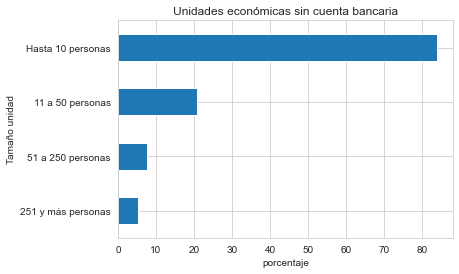

In [57]:
ax = dataplot_nocuenta.sort_values().plot.barh(legend=False, figsize=(6, 4))
ax.set_title('Unidades económicas sin cuenta bancaria')
ax.set_xlabel('porcentaje')
ax.set_ylabel('Tamaño unidad')
ax.figure.savefig('graficas/09_ue_nocuenta.png', dpi=600, bbox_inches='tight')


In [ ]:
dataplot_nocuenta